In [1]:
import pandas as pd
import joblib
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
import graphviz

In [5]:
#adjustable variables
yearly_data_path = 'path/to/yearly/data/'
modelling_year = 2001
delay_group_threshold = 4

In [6]:
year_df = pd.read_csv(f'{yearly_data_path}{modelling_year}.csv')

In [7]:
def bin_time(crs_time):
    bin_dict = {0: '00-06', 1: '06-12', 2: '12-18', 3: '18-00'}
    if crs_time == 2400:
        return '18-00'
    return bin_dict[crs_time // 600]

def get_season(month):
    season_dict = {(1,2,3): 'spring', (4,5,6): 'summer', (7,8,9): 'autumn', (10,11,12): 'winter'}
    for key, val in season_dict.items():
        if month in key:
            return val

In [8]:
#preprocessing
arr_use_cols = ['MONTH', 'DAY_OF_WEEK', 'CRS_ARR_TIME', 'DISTANCE', 'PRCP_DEST', 'SNOW_DEST', 'SNWD_DEST', 'TMAX_DEST', 'TMIN_DEST', 'ARR_DELAY_GROUP']
arr_df = year_df[arr_use_cols]
arr_df = arr_df[pd.notnull(arr_df['ARR_DELAY_GROUP'])]
arr_df['HAS_ARR_DELAY'] = arr_df['ARR_DELAY_GROUP'].apply(lambda x: 1 if x >= delay_group_threshold else 0)
arr_df['CRS_ARR_BIN'] = arr_df['CRS_ARR_TIME'].apply(bin_time)
arr_df['SEASON'] = arr_df['MONTH'].apply(get_season)
arr_df = arr_df.astype({'DAY_OF_WEEK': 'string'})

In [9]:
#train-test split
arr_regression_cols = ['SEASON', 'DAY_OF_WEEK', 'CRS_ARR_BIN', 'DISTANCE', 'PRCP_DEST', 'SNOW_DEST', 'SNWD_DEST', 'TMAX_DEST', 'TMIN_DEST']
arr_X = pd.get_dummies(arr_df[arr_regression_cols])
arr_X = arr_X.dropna()
arr_y = arr_df['HAS_ARR_DELAY']
arr_X_train, arr_X_test, arr_y_train, arr_y_test = train_test_split(arr_X, arr_y, test_size = 0.2)

In [ ]:
#train model
arr_rf = RandomForestClassifier()
arr_rf.fit(arr_X_train, arr_y_train)

In [2]:
#joblib.dump(arr_rf, 'arr_rf.joblib')
#arr_rf = joblib.load('arr_rf.joblib')

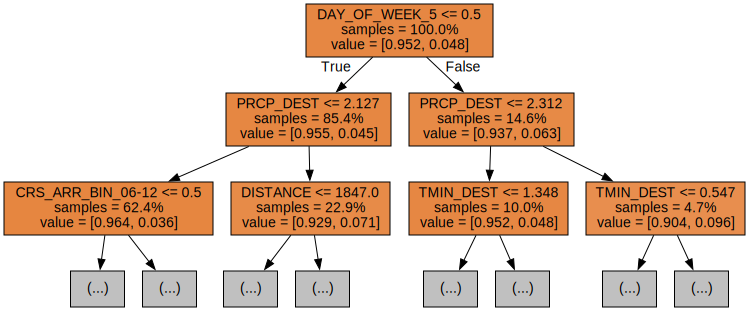

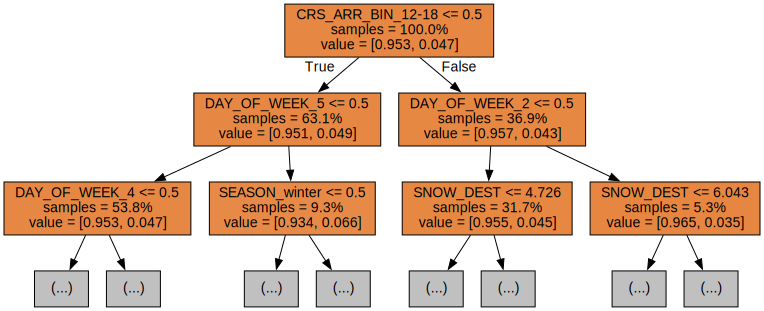

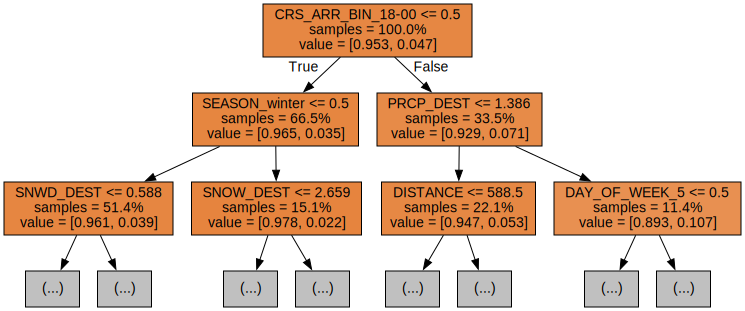

In [10]:
#evaluation
# Export the first three decision trees from the forest
for i in range(3):
    tree = arr_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=arr_X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [11]:
arr_y_pred = arr_rf.predict(arr_X_test)

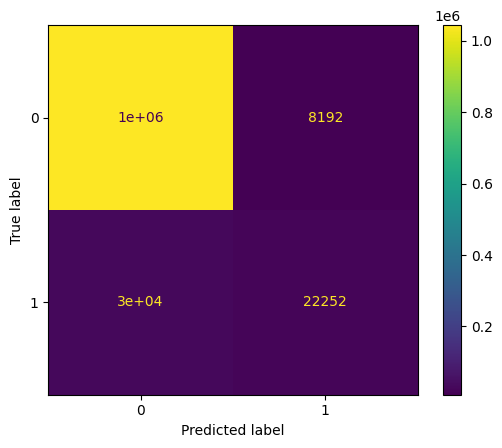

In [12]:
arr_cm = confusion_matrix(arr_y_test, arr_y_pred)
ConfusionMatrixDisplay(confusion_matrix=arr_cm).plot()

In [13]:
arr_accuracy = accuracy_score(arr_y_test, arr_y_pred)
arr_precision = precision_score(arr_y_test, arr_y_pred)
arr_recall = recall_score(arr_y_test, arr_y_pred)
print("Accuracy:", arr_accuracy)
print("Precision:", arr_precision)
print("Recall:", arr_recall)

Accuracy: 0.9653523281124843
Precision: 0.7309157797924057
Recall: 0.42513517128064043


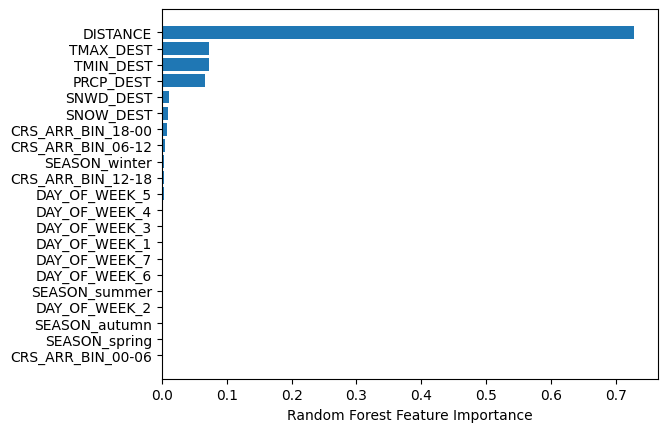

In [14]:
arr_feature_importances = pd.Series(arr_rf.feature_importances_, index=arr_X_train.columns).sort_values(ascending = False)
plt.barh(arr_feature_importances.index, arr_feature_importances.values)
plt.xlabel("Random Forest Feature Importance")
plt.gca().invert_yaxis()